In [1]:
import tensorflow as tf
import tensorflow_datasets as tfds

Loading and splitting the dataset.

In [2]:
fashion_mnist = tfds.image_classification.FashionMNIST()

In [3]:
dataset_train, dataset_test = fashion_mnist.as_dataset()["train"], fashion_mnist.as_dataset()["test"]

In [4]:
dataset_train = dataset_train.shuffle(buffer_size=2000)

In [5]:
dataset_size = len(dataset_train)
train_size = int(0.7*dataset_size)
val_size = dataset_size-train_size

In [6]:
dataset_val = dataset_train.take(val_size)
dataset_train = dataset_train.skip(val_size)

In [7]:
from tensorflow.train import Feature, Features, Example
from tensorflow.train import BytesList, FloatList, Int64List

Let's try saving the dataset.

In [8]:
def encode_fashion_mnist(example, label):
    
    image = tf.io.serialize_tensor(example).numpy()
    
    fashion_example = Example(
        features = Features(
            feature = {
                'image' : Feature(bytes_list=BytesList(value = [image])),
                'label' : Feature(int64_list=Int64List(value = [tf.cast(label, tf.int64)]))
            }
        )
    )
    
    return fashion_example.SerializeToString()

In [9]:
options = tf.io.TFRecordOptions(compression_type="GZIP")

outputs = ["train", "test", "val"]
sets = [dataset_train, dataset_test, dataset_val]

for output, dataset in zip(outputs, sets):
    filename = "fashion_mnist_compressed_" + output + ".tfrecord"
    with tf.io.TFRecordWriter(filename, options) as f:
        for sample in dataset:
            parsed = encode_fashion_mnist(sample["image"], sample["label"])
            f.write(parsed)

And now for the loading.

In [62]:
feature_description = {
    "image" : tf.io.FixedLenFeature([], tf.string, default_value=b""),
    "label" : tf.io.FixedLenFeature([], tf.int64, default_value=0)
}

train_test_val = [None, None, None]

for inp, (idx, _) in zip(outputs, enumerate(train_test_val)):
    filename = "fashion_mnist_compressed_" + inp + ".tfrecord"
    dataset = tf.data.TFRecordDataset([filename], compression_type="GZIP")
    dataset = dataset.map(lambda x : tf.io.parse_single_example(x, feature_description), num_parallel_calls=8)
    dataset = dataset.map(lambda x : (tf.io.parse_tensor(x["image"], tf.uint8), x["label"]), num_parallel_calls=8)
    if idx == 0:
        dataset = dataset.shuffle(buffer_size = 4000).repeat(10).batch(64).prefetch(2)
    else:
        dataset = dataset.batch(64)
    train_test_val[idx] = dataset
    
dataset_train, dataset_test, dataset_val = train_test_val

In [63]:
import tensorflow.keras as keras
input_shape = None

for sample in dataset_train.take(1):
    input_shape = sample[0].shape[1:]

In [64]:
input_layer = keras.layers.Input(shape=input_shape)
flatten_layer = keras.layers.Flatten()(input_layer)
normalization = keras.layers.LayerNormalization()(flatten_layer)
wide_1 = keras.layers.Dense(300, activation="relu")(normalization)
wide_batch_1 = keras.layers.BatchNormalization()(wide_1)
wide_2 = keras.layers.Dense(300, activation="relu")(wide_batch_1)
wide_batch_2 = keras.layers.BatchNormalization()(wide_2)
deep = normalization
for i in range(6):
    deep = keras.layers.Dense(50, activation="relu")(normalization)
    deep = keras.layers.BatchNormalization()(deep)
concat = keras.layers.Concatenate()([wide_batch_2, deep])
softmax = keras.layers.Dense(10, activation="softmax")(concat)

model = keras.models.Model(inputs=input_layer, outputs=softmax)

model.save_weights("temp_weights.h5")

In [65]:
model.compile(
    loss = "sparse_categorical_crossentropy",
    metrics = ["sparse_categorical_accuracy"],
    optimizer = keras.optimizers.SGD(learning_rate=0.001)
)

In [66]:
history = model.fit(dataset_train, epochs=1).history

6563/6563 [==============================] - 26s 4ms/step - loss: 0.5133 - sparse_categorical_accuracy: 0.8225


Finding the optimal learning rate.

In [67]:
import numpy as np

learning_rates = np.logspace(-10, -1, 15)
print(learning_rates)

[1.00000000e-10 4.39397056e-10 1.93069773e-09 8.48342898e-09
 3.72759372e-08 1.63789371e-07 7.19685673e-07 3.16227766e-06
 1.38949549e-05 6.10540230e-05 2.68269580e-04 1.17876863e-03
 5.17947468e-03 2.27584593e-02 1.00000000e-01]


In [68]:
losses = []

for learning_rate in learning_rates:
    model.compile(
        loss = "sparse_categorical_crossentropy",
        metrics = ["sparse_categorical_accuracy"],
        optimizer = keras.optimizers.Nadam(learning_rate=learning_rate)
    )
    model.load_weights("temp_weights.h5")
    loss = model.fit(dataset_train).history["loss"]
    losses.append(loss)

6563/6563 [==============================] - 38s 6ms/step - loss: 0.7604 - sparse_categorical_accuracy: 0.8252


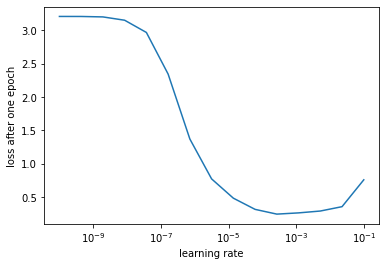

In [69]:
import matplotlib.pyplot as plt

plt.plot(learning_rates, losses)
plt.xlabel("learning rate")
plt.xscale("log")
plt.ylabel("loss after one epoch")
plt.show()

In [70]:
final_lr = 1e-3*0.7

In [71]:
model.compile(
    loss = "sparse_categorical_crossentropy",
    metrics = ["sparse_categorical_accuracy"],
    optimizer = keras.optimizers.Nadam(learning_rate=final_lr)
)

In [72]:
model.load_weights("temp_weights.h5")

In [76]:
dataset_train = dataset_train.repeat(200//6)

model.fit(dataset_train, validation_data=dataset_val, steps_per_epoch = 1000,
         epochs = 200, callbacks=[keras.callbacks.EarlyStopping(patience=20, restore_best_weights=True)])

Epoch 1/200
1000/1000 [==============================] - 7s 7ms/step - loss: 0.0858 - sparse_categorical_accuracy: 0.9685 - val_loss: 0.4166 - val_sparse_categorical_accuracy: 0.8947
Epoch 2/200
1000/1000 [==============================] - 7s 7ms/step - loss: 0.0790 - sparse_categorical_accuracy: 0.9709 - val_loss: 0.4437 - val_sparse_categorical_accuracy: 0.8971
Epoch 3/200
1000/1000 [==============================] - 7s 7ms/step - loss: 0.0749 - sparse_categorical_accuracy: 0.9722 - val_loss: 0.4685 - val_sparse_categorical_accuracy: 0.8932
Epoch 4/200
1000/1000 [==============================] - 7s 7ms/step - loss: 0.0661 - sparse_categorical_accuracy: 0.9760 - val_loss: 0.4764 - val_sparse_categorical_accuracy: 0.8953
Epoch 5/200
1000/1000 [==============================] - 8s 8ms/step - loss: 0.0612 - sparse_categorical_accuracy: 0.9777 - val_loss: 0.4714 - val_sparse_categorical_accuracy: 0.8974
Epoch 6/200
1000/1000 [==============================] - 7s 7ms/step - loss: 0.0606 -

In [77]:
model.evaluate(dataset_test)

157/157 [==============================] - 0s 3ms/step - loss: 0.4662 - sparse_categorical_accuracy: 0.8879


[0.4661714434623718, 0.8878999948501587]